In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
# read input file
filepath = "space_mountain_with_holiday_weather_lag_suite.csv"
df = pd.read_csv(filepath)

In [3]:
# one hot encode the Day of Week column
df = pd.get_dummies(df, columns=['Day of Week']) 

In [4]:
# ------ SPLITTING DATASET ------
train_years = ['14', '15', '16', '17', '18', '19', '22']
test_years = ['23', '24', '25']

df['Year'] = df['Date'].apply(lambda x: x.split('/')[-1])
df = df[df['Time of Day'] >= 450]
df['Time_sq'] = df['Time of Day'] ** 2
df['Time_sin'] = np.sin(2 * np.pi * df['Time of Day'] / 1440)
df['Time_cos'] = np.cos(2 * np.pi * df['Time of Day'] / 1440)

train_df = df[df['Year'].isin(train_years)]
test_df = df[df['Year'].isin(test_years)]

In [ ]:
# get feature matrices and labels
y_train = train_df['Wait Time'].values
X_train = train_df.drop(columns=['Wait Time', 'Date', 'Time', 'Year'])
y_test = test_df['Wait Time'].values
X_test = test_df.drop(columns=['Wait Time', 'Date', 'Time', 'Year'])

In [6]:
# normalize features (important for MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# create and train MLP model
mlp = MLPRegressor(hidden_layer_sizes=(64,),  # one hidden layer with 64 neurons
                   activation='relu',
                   solver='adam',
                   max_iter=300,
                   random_state=42)
mlp.fit(X_train_scaled, y_train)

/Users/jeremypogue/miniforge3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(64,), max_iter=300, random_state=42)

In [8]:
# predict and evaluate
y_pred = mlp.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("MLP RMSE: {:.2f}".format(rmse))

MLP RMSE: 17.56


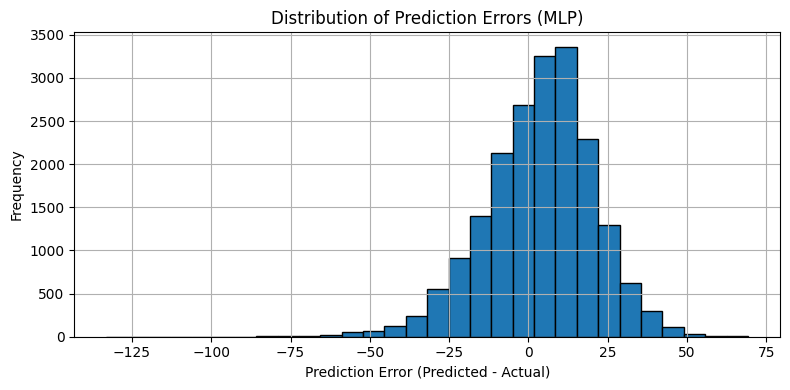

In [9]:
# error distribution
errors = y_pred - y_test
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Distribution of Prediction Errors (MLP)")
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()